# Initial imports

In [1]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import copy
import scipy
import pycircstat
import pickle

# pyro
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import poutine

# scRNA-seq
import scanpy as sc
import anndata

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(limits=8)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
USE_GPU = False
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use CPU


# Load data

In [4]:
import scvelo as scv

In [5]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

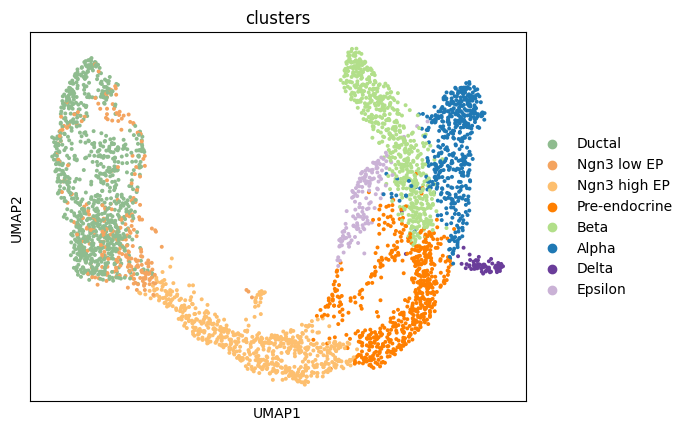

In [6]:
sc.pl.umap(adata, color='clusters')

Pre-filter genes

In [7]:
adata = adata[adata.obs["clusters"].isin(["Ngn3 high EP", "Pre-endocrine", "Beta"])].copy()
adata

AnnData object with n_obs × n_vars = 1825 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

In [9]:
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm)
sc.pp.log1p(adata_norm)

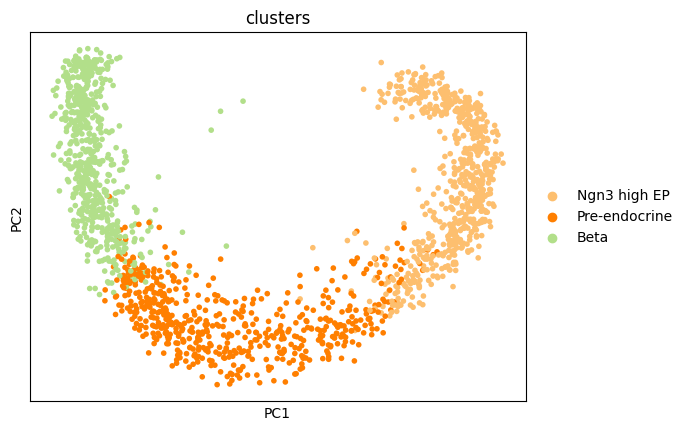

In [10]:
sc.tl.pca(adata_norm)
sc.pl.pca(adata_norm, color='clusters')

In [11]:
sc.pp.neighbors(adata_norm, n_neighbors=30, n_pcs=5)
sc.tl.diffmap(adata_norm, n_comps=3, neighbors_key=None)

In [12]:
adata_norm.uns['iroot'] = np.flatnonzero(adata_norm.obs['clusters'] == "Ngn3 high EP")[-2]

In [13]:
sc.tl.dpt(adata_norm, n_dcs=2)

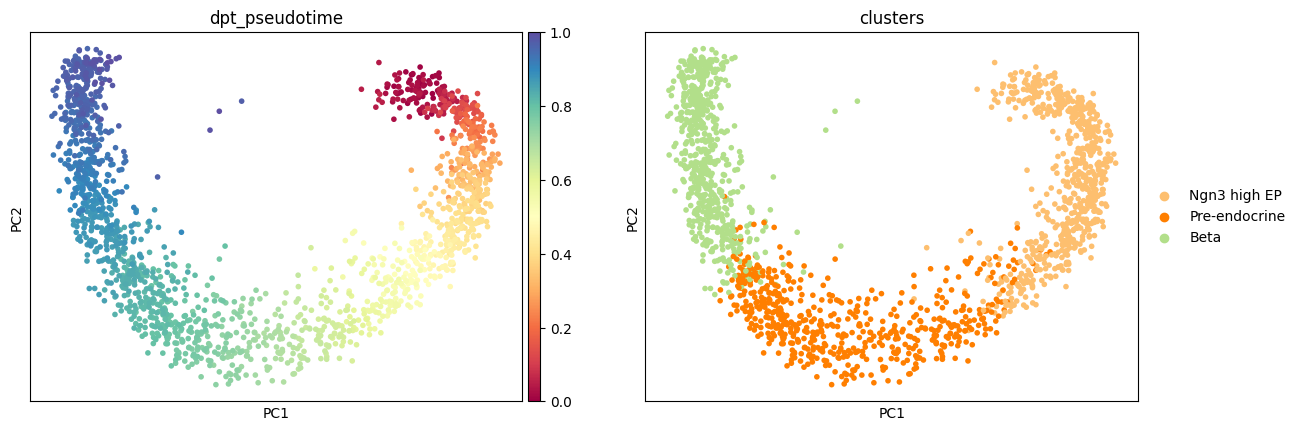

In [14]:
sc.pl.pca(adata_norm, color=["dpt_pseudotime", "clusters"], cmap=plt.cm.Spectral)

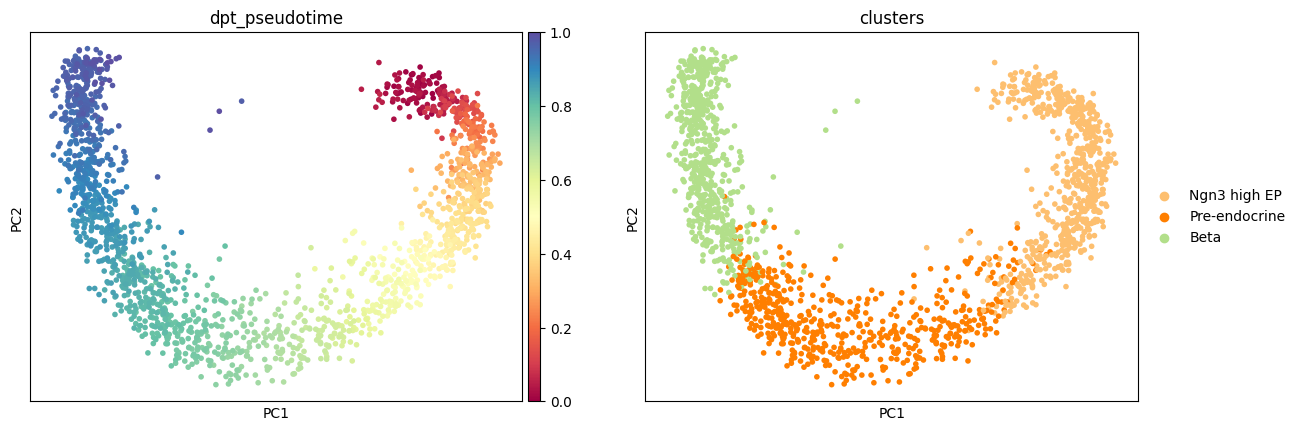

In [15]:
sc.pl.pca(adata_norm, color=["dpt_pseudotime", "clusters"], cmap=plt.cm.Spectral, save="Pancreas_BetaLinear_Pseudotime.pdf")

In [16]:
sc.pp.filter_genes(adata, min_cells=int((adata.n_obs)*0.05))

In [17]:
data = adata
data.obs["dpt_pseudotime"] = adata_norm.obs["dpt_pseudotime"]

In [18]:
data.obs["batch"] = "pancreas_beta"
data

AnnData object with n_obs × n_vars = 1825 × 2076
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'dpt_pseudotime', 'batch'
    var: 'highly_variable_genes', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [19]:
# Perform some very basic gene filtering by unspliced counts
data = data[:, (data.layers["unspliced"].toarray().mean(0) > 0.1)].copy()

# Perform some very basic gene filtering by spliced counts
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.3].copy()

In [20]:
data

AnnData object with n_obs × n_vars = 1825 × 263
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'dpt_pseudotime', 'batch'
    var: 'highly_variable_genes', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [21]:
def normalize_total(anndata):
    anndata.obs["n_scounts"] = anndata.layers["spliced"].toarray().sum(1)
    anndata.obs["n_ucounts"] = anndata.layers["unspliced"].toarray().sum(1)
    norm_factors = np.mean(anndata.obs["n_scounts"]) / np.array(anndata.obs["n_scounts"])
    anndata.layers["S_sz"] = (norm_factors * anndata.layers["spliced"].toarray().T).T
    norm_factors = np.mean(anndata.obs["n_ucounts"]) / np.array(anndata.obs["n_ucounts"])
    anndata.layers["U_sz"] = (norm_factors * anndata.layers["unspliced"].toarray().T).T

# Create size-normalized data layers
normalize_total(data)

In [22]:
full_keep_genes = np.array(data.var.index)

# Prepare for manifold-learning step

In [23]:
# UTILITIES

def circ_median(val, axis=0):
    return pycircstat.percentile(val, 50, np.array([0.0]), axis=axis)

def check_model(model, *args):
    pyro.clear_param_store()
    trace = poutine.trace(model).get_trace(*args)
    #trace.compute_log_prob()
    print(trace.format_shapes())
    return pyro.render_model(model, model_args=args)

def squeeze_left(a):
    for i, s in enumerate(a.shape):
        if s == 1:
            pass
        else:
            final_shape = a.shape[i:]
            break
    return a.reshape(final_shape)

import functools

def init_try(seed, model, guide, optim, elbo, warmup, *args):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    svi = SVI(model, guide, optim, loss=elbo)
    for i in range(warmup):
        svi.step(*args)
    loss = svi.loss(model, guide, *args)
    pyro.clear_param_store()
    return loss

def find_best_seed(model, guide_type, optim, elbo, init_loc_fn, *args, n_inits=20, warmup=5):
    pyro.clear_param_store()
    losses = []
    for seed in range(n_inits):
        guide = guide_type(model, init_loc_fn=init_loc_fn)
        loss = init_try(seed, model, guide, optim, elbo, warmup, *args)
        pyro.clear_param_store()
        losses.append(loss)
        print(f"Initialization Attempt with Seed={seed} - Loss was {loss}")
    pyro.clear_param_store()
    return np.argmin(losses), losses

class FitResults(object): pass

def live_plot(data_dict, figsize=(16,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.subplot(121)
    for label, data in data_dict.items():
        if isinstance(label, int):
            plt.scatter(np.full( len(data), label), data,
                        marker="X", s=50, c="r")
        else:
            plt.plot(data, label=label, c="C0")
    plt.axhline(np.min(data), c="r")
    plt.title("All iterations") 
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    for label,data in data_dict.items():
        if isinstance(label, int):
            continue
        plt.plot(data, label=label, c="C2")
    plt.title("Last 100 iterations") 
    plt.axhline(np.min(data), c="r")
    plt.xlim(len(data)-200, len(data))
    plt.ylim(np.min(data)-10, np.max(data[-200:]))
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();
    
def fit_SVI(model, guide_type, init_loc_fn, *args, initialization=False, n_inits=20, warmup=5,
            n_iter = 3000, lr = 0.01, betas = [0.8, 0.99]):
    
    pyro.clear_param_store()
    ploting_data = collections.defaultdict(list)
    
    print("Clear Parameter Store")
    optim = pyro.optim.Adam({'lr': lr, 'betas': betas})
    elbo = Trace_ELBO()
    if initialization:
        best_seed, init_losses = find_best_seed(model, guide_type, optim, elbo,  init_loc_fn, *args,
                                                n_inits=n_inits, warmup=warmup)
        ploting_data[warmup] = init_losses
        pyro.set_rng_seed(best_seed)
    guide = guide_type(model, init_loc_fn=init_loc_fn)
    svi = SVI(model, guide, optim, loss=elbo)
    print("Initializing SVI...")
    t0 = time.time()
    init_loss = svi.loss(model, guide, *args)
    loss = svi.step(*args)
    t1 = time.time()
    print(f"ELBO loss at initialization: {init_loss}  -  Single step takes {t1-t0:.2e} seconds")
    
    losses = []
    current_min = np.inf
    
    for i in range(n_iter):
        loss = svi.step(*args)
        losses.append(loss)
        if loss < current_min:
            map_estimates = guide(*args)
            pmstore_minstate = deepcopy(dict(pyro.get_param_store().get_state()))
            loss_ix = i
            current_min = loss
        if i > 5 and i % 40 == 0:
            #print('50-', end='')
            ploting_data['ELBO'] = losses
            live_plot(ploting_data)
    
    print(f"ELBO loss at initialization: {init_loss}  -  Single step takes {t1-t0:.2e} seconds")
    print(f"\nThe optimization run for {n_iter} iterations and found the minimum loss at the {loss_ix} iteration.")
    print(f"The minimum loss is {current_min}.")
    
    print(f"Setting the state parameter store to the minimum instead of the endstate")
    map_estimates_end = guide(*args)
    pmstore_endstate = deepcopy(dict(pyro.get_param_store().get_state()))     
    pyro.get_param_store().set_state(pmstore_minstate)
    
    print(f"Outputing the fit results")
    res = FitResults()
    res.losses = losses
    res.minloss = current_min
    res.itermin = loss_ix
    #res.pmstore_endstate = pmstore_endstate
    res.pmstore_minstate = pmstore_minstate
    res.map_estimates_min = map_estimates
    #res.map_estimates_end = map_estimates_end
    
    return res

In [24]:
from splines_torch import *

In [25]:
def phase_latent_variable_model(mp):
    device = mp.device  # Assuming mp object has an attribute specifying the device
    
    # Plates initialization
    cell_plate = pyro.plate("cells", mp.Nc, dim=-1, device=device)
    gene_plate = pyro.plate("genes", mp.Ng, dim=-2, device=device)

    with gene_plate:
        ν = pyro.sample("ν", dist.Normal(mp.μν.to(device), mp.σν.to(device)).to_event(1))
        
    with cell_plate:
        if mp.ϕ is None:
            ϕ = pyro.sample("ϕ", dist.Uniform(mp.ø, mp.χ))
        else:
            ϕ = mp.ϕ
            pyro.deterministic("ϕ", ϕ)
            
        ζ = torch_spline_basis(ϕ.squeeze(), mp.spline_t, mp.spline_k, prepend=1)
        pyro.deterministic("ζ", ζ)

    ElogS = torch.einsum("...gch,ch->gc", ν, ζ) + mp.count_factor.to(device)
    pyro.deterministic("ElogS", ElogS)

    with gene_plate:
        shape_inv = pyro.sample("shape_inv", dist.Gamma(mp.gamma_alpha.to(device), mp.gamma_beta.to(device)))
    with cell_plate, gene_plate:
        pyro.sample("S",dist.GammaPoisson(1.0 / shape_inv, 1.0 / (shape_inv * torch.exp(ElogS))), obs=mp.S.to(device))

In [26]:
data_to_fit = data[:, [i in full_keep_genes for i in data.var.index]].copy()

In [27]:
data_to_fit

AnnData object with n_obs × n_vars = 1825 × 263
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'dpt_pseudotime', 'batch', 'n_scounts', 'n_ucounts'
    var: 'highly_variable_genes', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'S_sz', 'U_sz'
    obsp: 'distances', 'connectivities'

In [28]:
from collections import namedtuple

metapars = dict(
    ø = 0.0,
    χ = 10.0,
    
    # Parameters for ν 
    spline_df = 5,
    spline_degree = 3,
    μμν0 = 0.0,
    σμν0 = 0.6,
    μμνi = -0.2,
    σμνi = 1.5,

    # Parameters for ω
    ωspline_df = 4,
    ωspline_degree = 3,
    μω0 = 0.5,
    σω0 = 0.03,
    μωi = 0.0,
    σωi = 0.2,
    
    μω = 0.5,
    σω = 0.25,
        
    Ng = data_to_fit.n_vars,
    Nc = data_to_fit.n_obs,

    device=device,
    gamma_alpha=torch.tensor(1.0).float(),
    gamma_beta=torch.tensor(2.0).float(),

    ϕ=None,
)

MetaparContainer = namedtuple("MetaparContainer", list(metapars.keys()) )
mp = MetaparContainer(**metapars)

# add_precomputed_metapars
t, k = spline_prep(lower_bound=mp.ø, upper_bound=mp.χ, df=mp.spline_df, degree=mp.spline_degree)
tder, c, kder = derivative(t, k)

tω, kω = spline_prep(lower_bound=mp.ø, upper_bound=mp.χ,
                   df=mp.ωspline_df, degree=mp.ωspline_degree)

Nh = len(t) - k # do not subtract 1 because we add the flat basis
Nhω = len(tω) - kω # do not subtract 1 because we add the flat basis

μν = torch.zeros(Nh)
μν[0] = mp.μμν0
μν[1:] = mp.μμνi

σν = torch.zeros(Nh)
σν[0] = mp.σμν0
σν[1:] = mp.σμνi

μνω = torch.Tensor([mp.μω0,] + [mp.μωi]*(Nhω-1))
σνω = torch.Tensor([mp.σω0] + [mp.σωi]*(Nhω-1))
    
S = torch.tensor(data_to_fit.layers["spliced"].A.astype(np.int64)).to(device)
U = torch.tensor(data_to_fit.layers["unspliced"].A.astype(np.int64)).to(device)

S = S.T.float().to(device)
U = U.T.float().to(device)

S_UMI_per_cell = torch.tensor(data_to_fit.layers["spliced"].sum(1).astype(np.int64)).T.float().to(device)
count_factor = torch.log(S_UMI_per_cell / torch.mean(S_UMI_per_cell)).to(device)

# Splicing and degradation rate params
μγ=torch.tensor(0.0).float()
σγ=torch.tensor(0.5).float()
μβ=torch.tensor(2.0).float()
σβ=torch.tensor(1.0).float()
μγ=μγ.float().repeat([mp.Ng, 1]).to(device)
σγ=σγ.float().repeat([mp.Ng, 1]).to(device)
μβ=μβ.float().repeat([mp.Ng, 1]).to(device)
σβ=σβ.float().repeat([mp.Ng, 1]).to(device)

precompvals = dict(S=S, 
                   U=U, 
                   μν=μν, 
                   σν=σν, 
                   μγ=μγ,
                   σγ=σγ,
                   μβ=μβ,
                   σβ=σβ,
                   μνω=μνω,
                   σνω=σνω,
                   count_factor=count_factor[None, None, :],
                   spline_t=torch.tensor(t, dtype=torch.float32),
                   spline_k=k,
                   spline_tder=torch.tensor(tder),
                   spline_c=torch.tensor(c, dtype=torch.float32),
                   spline_kder=kder,
                   spline_tω=torch.tensor(tω, dtype=torch.float32),
                   spline_kω=kω,
                   Nh=Nh,
                   Nhω=Nhω)

full_dict = mp._asdict()  | precompvals 
MetaparContainer = namedtuple("MetaparContainer", list(full_dict.keys()) )
mp = MetaparContainer(**full_dict)

 Trace Shapes:                               
  Param Sites:                               
 Sample Sites:                               
    cells dist              |                
         value         1825 |                
    genes dist              |                
         value          263 |                
        ν dist     263    1 |    6           
         value     263    1 |    6           
        ϕ dist         1825 |                
         value         1825 |                
        ζ dist         1825 | 1825 6         
         value              | 1825 6         
    ElogS dist              |    1 1 263 1825
         value              |    1 1 263 1825
shape_inv dist     263    1 |                
         value     263    1 |                
        S dist 1 1 263 1825 |                
         value     263 1825 |                


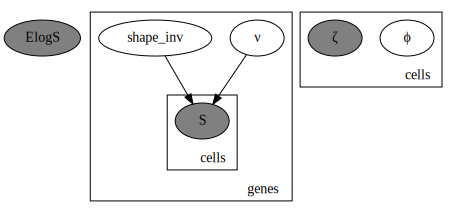

In [29]:
check_model(phase_latent_variable_model, mp)

In [30]:
precompvals = dict(ϕ=torch.tensor(data_to_fit.obs["dpt_pseudotime"]*10.0).float())

full_dict = mp._asdict()  | precompvals 
MetaparContainer = namedtuple("MetaparContainer", list(full_dict.keys()) )
mp = MetaparContainer(**full_dict)

In [31]:
condition_on = {"S":mp.S}
phase_model_full = pyro.condition(phase_latent_variable_model, data=condition_on)

In [32]:
from pyro.infer.autoguide import init_to_median
from pyro.infer.autoguide import AutoDiagonalNormal

import collections
import time
from copy import deepcopy
from IPython.display import clear_output
from pyro.infer import Predictive

 Trace Shapes:                               
  Param Sites:                               
 Sample Sites:                               
    cells dist              |                
         value         1825 |                
    genes dist              |                
         value          263 |                
        ν dist     263    1 |    6           
         value     263    1 |    6           
        ϕ dist         1825 | 1825           
         value              | 1825           
        ζ dist         1825 | 1825 6         
         value              | 1825 6         
    ElogS dist              |    1 1 263 1825
         value              |    1 1 263 1825
shape_inv dist     263    1 |                
         value     263    1 |                
        S dist 1 1 263 1825 |                
         value     263 1825 |                


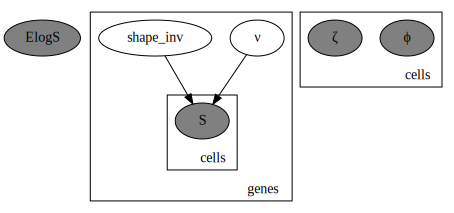

In [33]:
check_model(phase_model_full, mp)

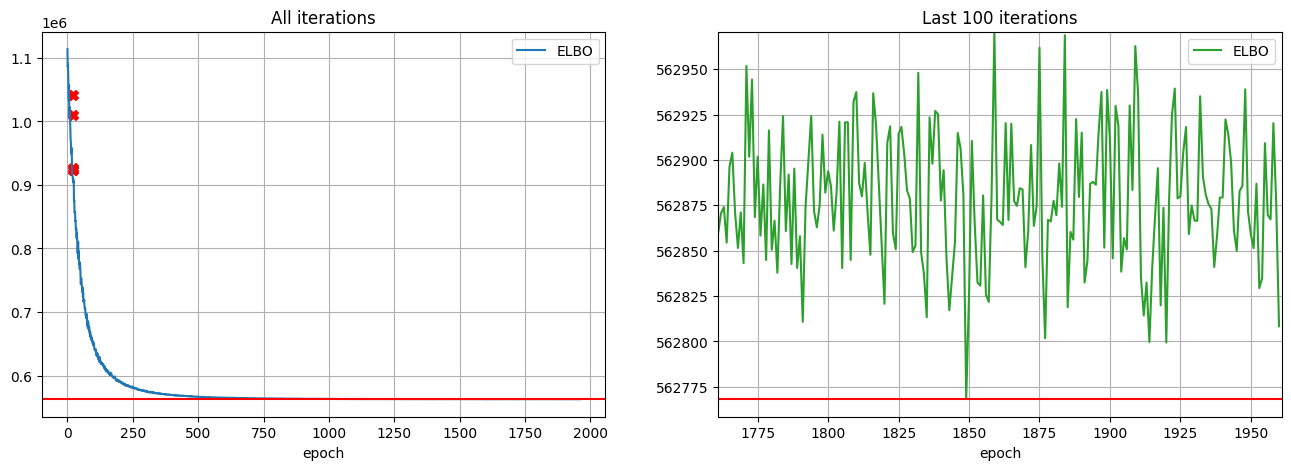

ELBO loss at initialization: 1110582.1428222656  -  Single step takes 4.20e-02 seconds

The optimization run for 2000 iterations and found the minimum loss at the 1849 iteration.
The minimum loss is 562768.5418252945.
Setting the state parameter store to the minimum instead of the endstate
Outputing the fit results


In [34]:
res = fit_SVI(phase_model_full, AutoDiagonalNormal, init_to_median,
              mp, initialization=True, n_inits=5, warmup=20, n_iter=2000)

In [35]:
meanfield = AutoDiagonalNormal(phase_model_full)
predictive = Predictive(phase_latent_variable_model, guide=meanfield, 
                        num_samples=200)
pps = predictive(mp) # posterior predictive samples

In [36]:
pps.keys()

dict_keys(['ν', 'shape_inv', 'ϕ', 'ζ', 'ElogS', 'S'])

In [37]:
ϕ_fit = pps["ϕ"].mean(0)
ν_fit = pps["ν"].mean(0)
ζ_fit = pps["ζ"].mean(0)
ElogS_fit = pps["ElogS"].mean(0).squeeze()
shape_inv_fit = pps["shape_inv"].mean(0).squeeze()

In [38]:
avg_count_factor = torch.mean(mp.count_factor)
ElogS2_fit = torch.einsum("gch,gch->gc", ν_fit, ζ_fit) + avg_count_factor

In [39]:
name2color = {i:j for i,j in zip(sorted(data.obs["clusters"].unique()), data.uns["clusters_colors"])}

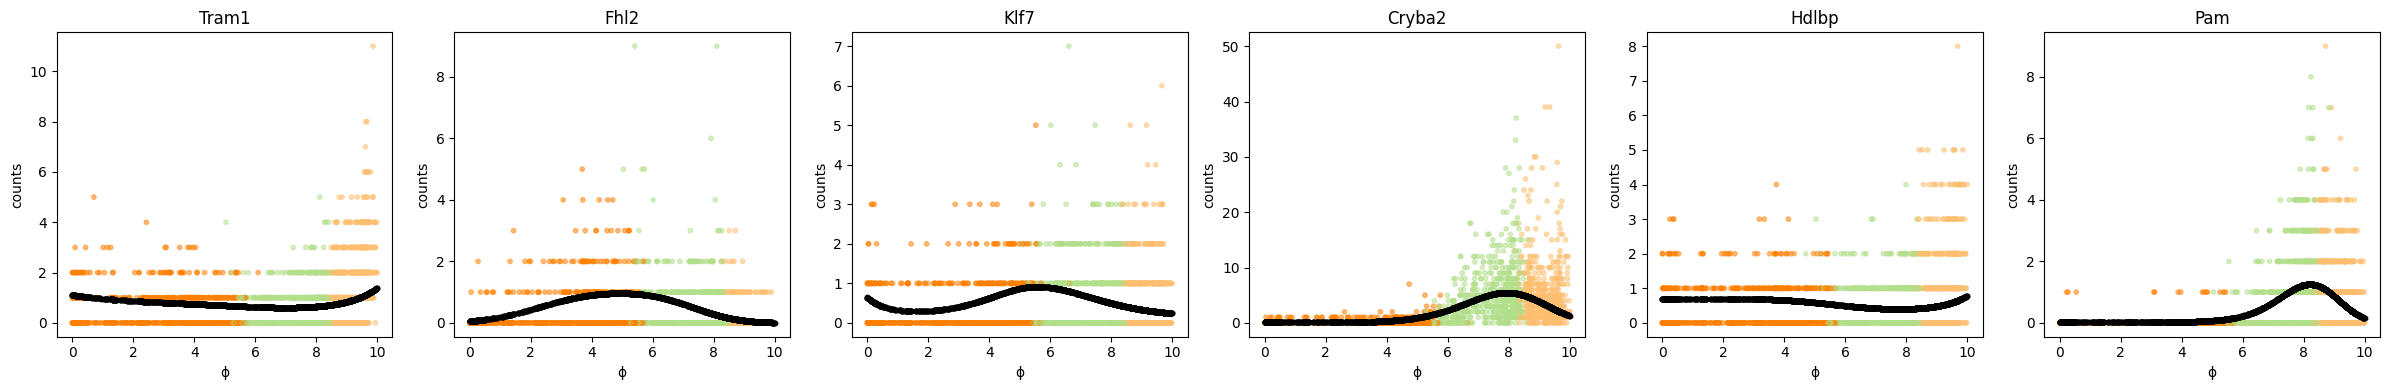

In [40]:
gene_list = np.array(data_to_fit.var.index)[:6]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(ϕ_fit, 
                mp.S[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["clusters"]])
    plt.scatter(ϕ_fit, 
                np.exp(ElogS2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
plt.tight_layout()
plt.show()

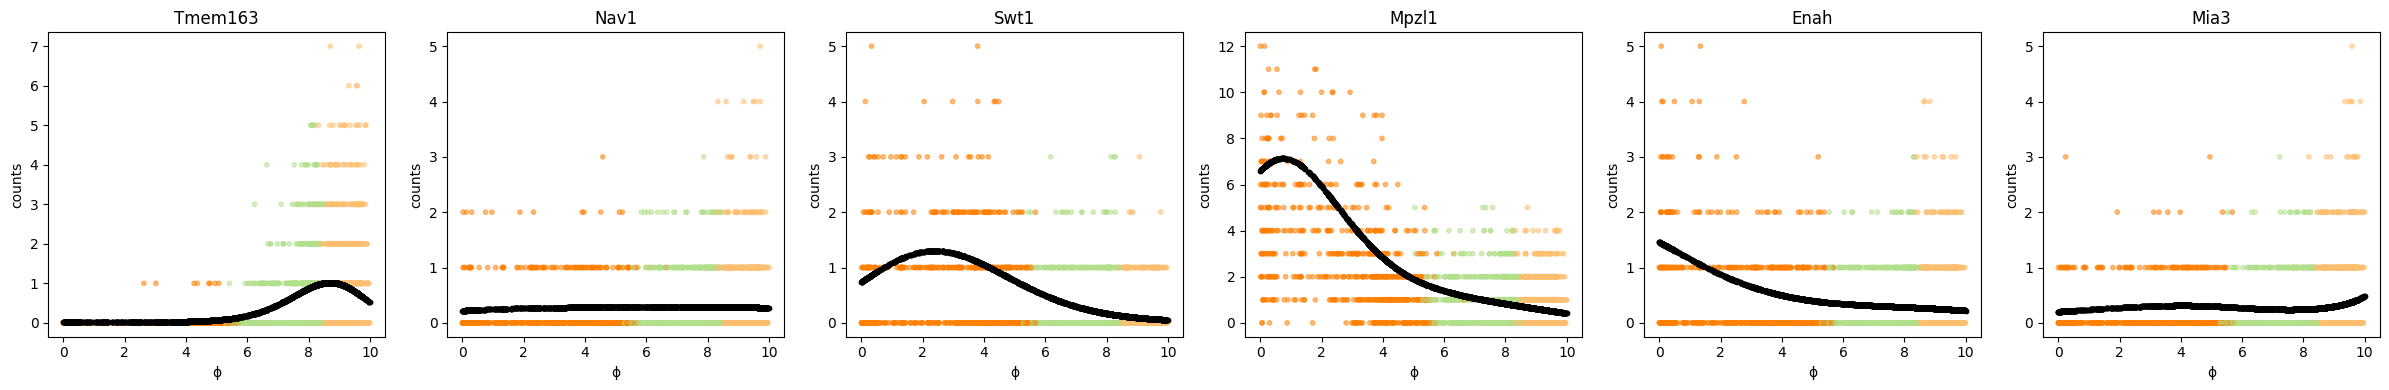

In [41]:
gene_list = np.array(data_to_fit.var.index)[6:12]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(ϕ_fit, 
                mp.S[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["clusters"]])
    plt.scatter(ϕ_fit, 
                np.exp(ElogS2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
plt.tight_layout()
plt.show()

# Velocity-learning

In [42]:
def velocity_latent_variable_model(mp):
    device=mp.device
    
    # Plates initialization
    cell_plate = pyro.plate("cells", mp.Nc, dim=-1, device=device)
    gene_plate = pyro.plate("genes", mp.Ng, dim=-2, device=device)
    harmonics_plate = pyro.plate("harmonics", mp.Nhω, dim=-3, device=device)
    
    # Generate beta and gamma distributions
    with gene_plate:
        logγg = pyro.sample("logγg", dist.Normal(mp.μγ.to(device), mp.σγ.to(device)))
        logβg = pyro.sample("logβg", dist.Normal(mp.μβ.to(device), mp.σβ.to(device)))
        
        γg = torch.exp(logγg)
        pyro.deterministic("γg", γg)
    
    with cell_plate:
        ζ_dϕ = torch_spline_basis(mp.ϕ.squeeze(), mp.spline_tder, mp.spline_kder, mp.spline_c, prepend=0)
        pyro.deterministic("ζ_dϕ", ζ_dϕ)
    
    ω = pyro.sample("ω", dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
    
    ElogU = -logβg + torch.log(torch.relu(torch.einsum("...gch,...ch->gc", mp.ν, ζ_dϕ) * ω + γg) + 1e-5) + mp.ElogS
    pyro.deterministic("ElogU", ElogU)

    shape_inv = mp.shape_inv
    with cell_plate, gene_plate:
        pyro.sample("S", dist.GammaPoisson(1.0 / shape_inv, 1.0 / (shape_inv * torch.exp(mp.ElogS))), obs=mp.S.to(device))
        pyro.sample("U", dist.GammaPoisson(1.0 / shape_inv, 1.0 / (shape_inv * torch.exp(ElogU))), obs=mp.U.to(device))

In [43]:
precompvals = dict(ϕ=ϕ_fit,
                   ζ=ζ_fit,
                   ν=ν_fit,
                   shape_inv=shape_inv_fit.unsqueeze(-1),
                  ElogS=ElogS_fit)

full_dict = mp._asdict()  | precompvals 
MetaparContainer = namedtuple("MetaparContainer", list(full_dict.keys()) )
mp = MetaparContainer(**full_dict)

 Trace Shapes:                     
  Param Sites:                     
 Sample Sites:                     
    cells dist          |          
         value     1825 |          
    genes dist          |          
         value      263 |          
harmonics dist          |          
         value        5 |          
    logγg dist 263    1 |          
         value 263    1 |          
    logβg dist 263    1 |          
         value 263    1 |          
       γg dist 263    1 |  263    1
         value          |  263    1
     ζ_dϕ dist     1825 | 1825    6
         value          | 1825    6
        ω dist          |          
         value          |          
    ElogU dist          |  263 1825
         value          |  263 1825
        S dist 263 1825 |          
         value 263 1825 |          
        U dist 263 1825 |          
         value 263 1825 |          


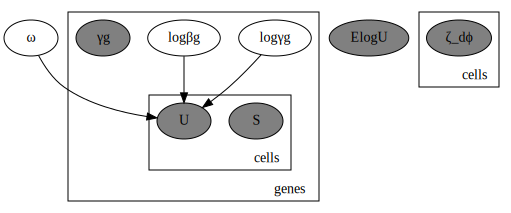

In [44]:
check_model(velocity_latent_variable_model, mp)

In [45]:
condition_on_velo = {"S":mp.S, 
                     "U":mp.U}
velocity_model_full = poutine.condition(velocity_latent_variable_model, data=condition_on_velo)

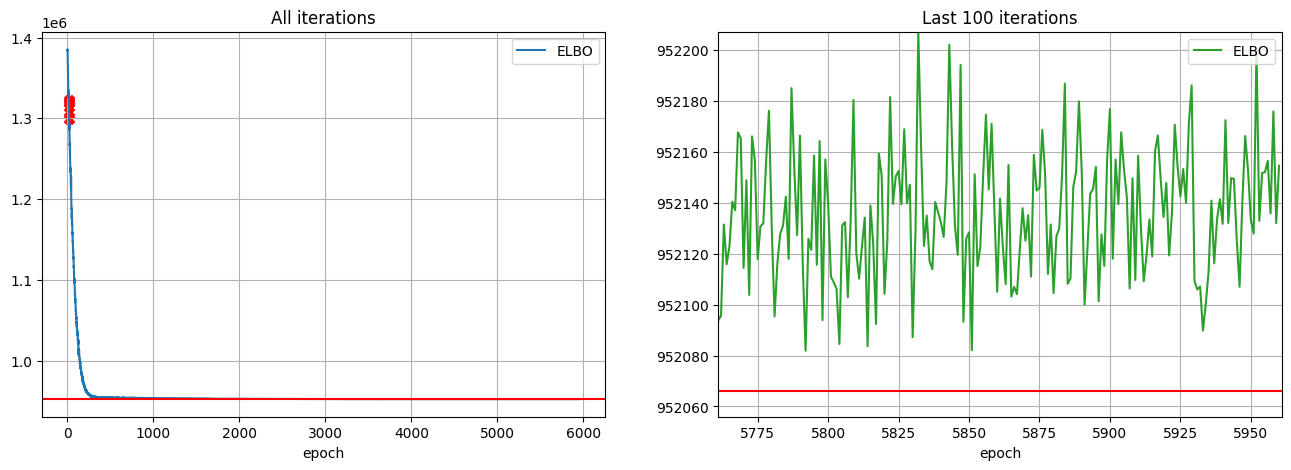

ELBO loss at initialization: 1388790.7626342773  -  Single step takes 5.89e-02 seconds

The optimization run for 6000 iterations and found the minimum loss at the 4629 iteration.
The minimum loss is 952065.9638306499.
Setting the state parameter store to the minimum instead of the endstate
Outputing the fit results


In [46]:
res_velo = fit_SVI(velocity_model_full, AutoDiagonalNormal, init_to_median,
              mp, initialization=True, n_inits=5, warmup=20, n_iter=6000)

In [47]:
meanfield_velo = AutoDiagonalNormal(velocity_model_full)
predictive_velo = Predictive(velocity_latent_variable_model, guide=meanfield_velo, 
                        num_samples=200)#, return_sites=['ν', 'ϕ', 'shape_inv', 'ζ', 'ElogS'])
pps_velo = predictive_velo(mp) # posterior predictive samples

In [48]:
pps_velo.keys()

dict_keys(['logγg', 'logβg', 'ω', 'γg', 'ζ_dϕ', 'ElogU', 'S', 'U'])

In [49]:
ω_fit = pps_velo["ω"].squeeze().mean(0)

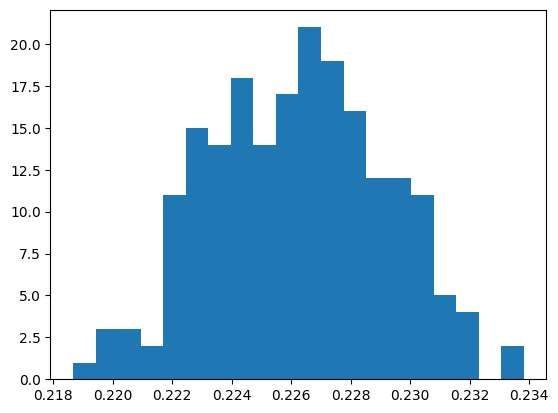

In [50]:
plt.hist(pps_velo["ω"].squeeze(), bins=20)
plt.show()

In [51]:
ω_fit5 = np.percentile(pps_velo["ω"].squeeze(), 5, axis=0)
ω_fit95 = np.percentile(pps_velo["ω"].squeeze(), 95, axis=0)

In [52]:
logγg_fit = pps_velo["logγg"].mean(0)
γg_fit = pps_velo["γg"].mean(0)
logβg_fit = pps_velo["logβg"].mean(0)
ElogU_fit = pps_velo["ElogU"].mean(0).squeeze()
ζ_dϕ_fit = pps_velo["ζ_dϕ"].mean(0).squeeze()

In [53]:
ElogU2_fit = -logβg_fit + torch.log(torch.relu(torch.einsum("gch,ch->gc", ν_fit, ζ_dϕ_fit) * ω_fit + γg_fit) + 1e-5) + ElogS2_fit

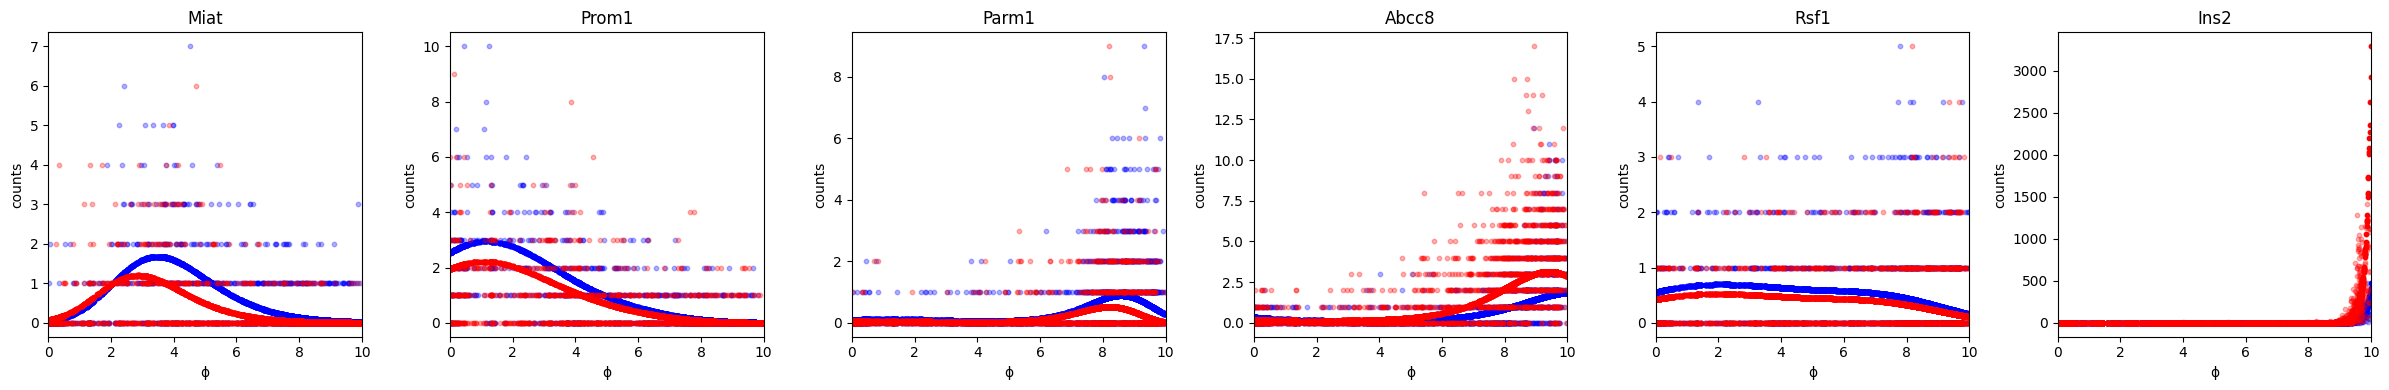

In [54]:
name2color = {i:j for i,j in zip(sorted(data.obs["clusters"].unique()), data.uns["clusters_colors"])}
gene_list = ["Miat", "Prom1", "Parm1", "Abcc8", "Rsf1", "Ins2"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(ϕ_fit, 
                mp.S[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, c='blue', alpha=0.3)
    plt.scatter(ϕ_fit, 
                np.exp(ElogS2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="blue")
    plt.scatter(ϕ_fit, 
                mp.U[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, c='red', alpha=0.3)
    plt.scatter(ϕ_fit, 
                np.exp(ElogU2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="red")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    plt.xlim(0, 10)
    ix+=1
plt.tight_layout()
plt.show()


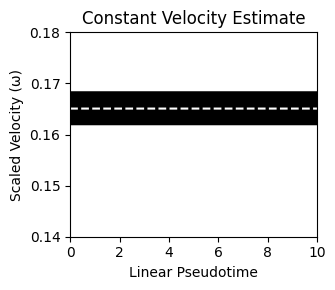

In [55]:
plt.figure(None, (9, 3))
plt.subplot(1, 3, 1)
full_pps_velo = pps_velo
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = data_to_fit.obs["dpt_pseudotime"]*10
plt.plot(phi[np.argsort(phi)], omega.mean(0).repeat(len(phi)), c="white", linestyle='dashed')
tmp5 = np.percentile(omega, 5, axis=0)
tmp95 = np.percentile(omega, 95, axis=0)
plt.fill_between(x=phi[np.argsort(phi)],
                     y1=tmp5.repeat(len(phi)), 
                     y2=tmp95.repeat(len(phi)), 
                     alpha=1, color="black")#colors[i], label = labels[i])
#plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.ylim(0.14, 0.18)
plt.xlim(0, 10)
plt.xlabel("Linear Pseudotime")
plt.ylabel("Scaled Velocity (ω)") 
plt.title("Constant Velocity Estimate")

plt.tight_layout()
plt.show()

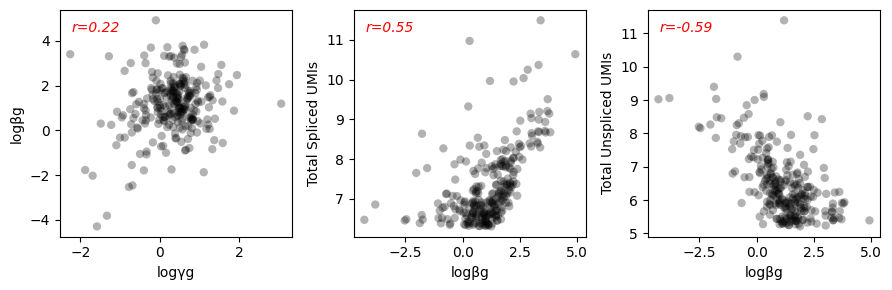

In [56]:
from scipy.stats import pearsonr
def add_pearson_corr_text(x, y, ax):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={corr:.2f}", color='red', ha='left', va='top', transform=ax.transAxes, style='italic')

plt.figure(None, (9,3))
ax1 = plt.subplot(1,3,1)
plt.scatter(logγg_fit.squeeze(), logβg_fit.squeeze(), edgecolor='none', alpha=0.3, c='black', rasterized=True)
plt.xlabel("logγg")
plt.ylabel("logβg")
add_pearson_corr_text(logγg_fit.squeeze(), logβg_fit.squeeze(), ax1)

ax2 = plt.subplot(1,3,2)
plt.scatter(logβg_fit.squeeze(), np.log(mp.S.sum(1)), edgecolor='none', alpha=0.3, c='black',rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Spliced UMIs")
add_pearson_corr_text(logβg_fit.squeeze(), np.log(mp.S.sum(1)), ax2)

ax3 = plt.subplot(1,3,3)
plt.scatter(logβg_fit.squeeze(), np.log(mp.U.sum(1)), edgecolor='none', alpha=0.3,c='black',rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Unspliced UMIs")
add_pearson_corr_text(logβg_fit.squeeze(), np.log(mp.U.sum(1)), ax3)

plt.tight_layout()
plt.show()

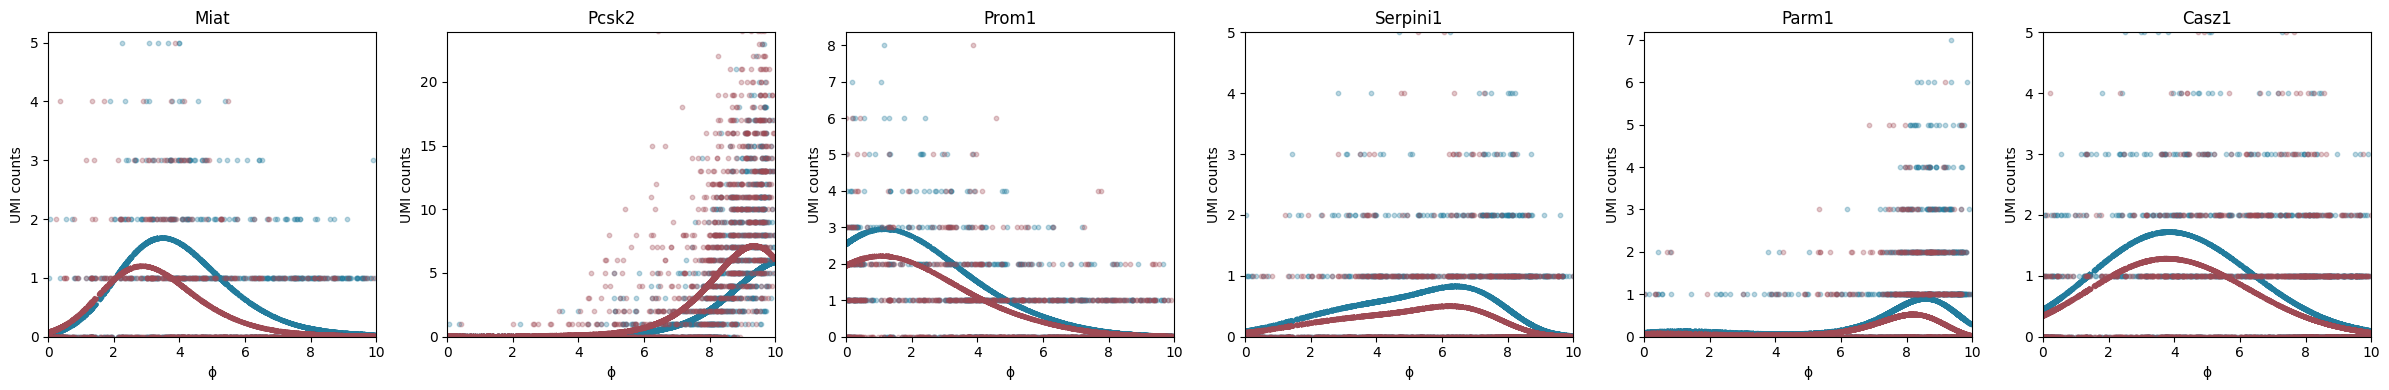

In [57]:
name2color = {i:j for i,j in zip(sorted(data.obs["clusters"].unique()), data.uns["clusters_colors"])}
#name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["Miat", "Pcsk2", "Prom1", "Serpini1", "Parm1", "Casz1"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(ϕ_fit, 
                mp.S[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, c="#227c9d", rasterized=True, alpha=0.3)
    plt.scatter(ϕ_fit, 
                np.exp(ElogS2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="#227c9d", linestyle='dashed', rasterized=True)
    plt.scatter(ϕ_fit, 
                mp.U[np.where(gene_names==g)[0][0], :].squeeze().numpy(), #.cpu()
                s=10, c='#9f4a54', rasterized=True, alpha=0.3)
    plt.scatter(ϕ_fit, 
                np.exp(ElogU2_fit[np.where(gene_names==g)[0][0], :]), 
                s=10, c="#9f4a54", linestyle='dashed',rasterized=True)
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("UMI counts")
    plt.xlim(0, 10)
    plt.ylim(0, np.percentile(mp.S[np.where(gene_names==g)[0][0], :].squeeze().numpy(), 99.9))
    ix+=1
plt.tight_layout()
plt.show()

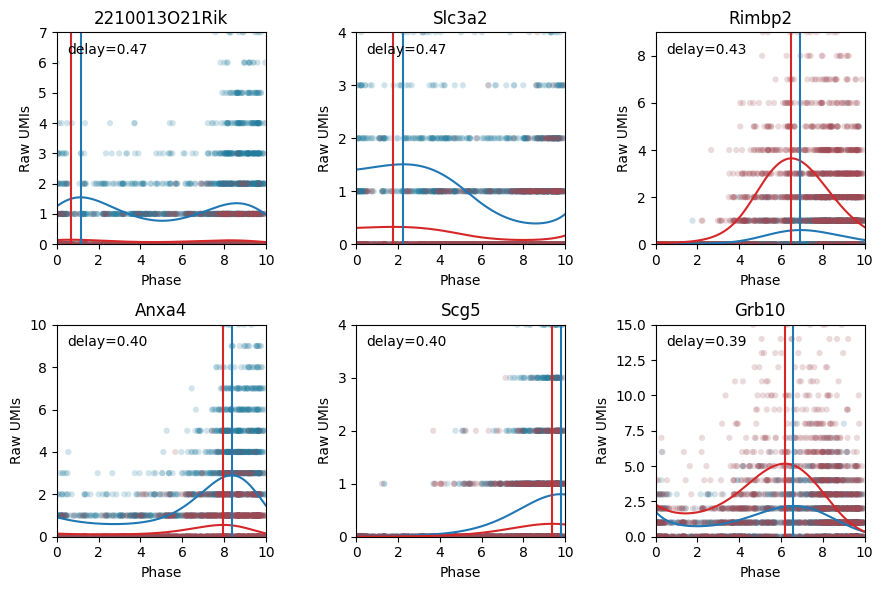

In [58]:
S = data_to_fit.layers["spliced"].toarray()
U = data_to_fit.layers["unspliced"].toarray()
phis = np.array(data_to_fit.obs["dpt_pseudotime"])*10
ElogU = ElogU2_fit.T
ElogS = ElogS2_fit.T

SPLICED_COLOR = "#227c9d"
UNSPLICED_COLOR = "#9f4a54"
genes = ['2210013O21Rik', 'Slc3a2', 'Rimbp2', 'Anxa4', 'Scg5', 'Grb10']
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for ax, gene in zip(axes.ravel(), genes):
    gix = np.where(data_to_fit.var.index == gene)[0]
    phis_order = np.argsort(phis)
    ax.scatter(phis, S[:, gix], c=SPLICED_COLOR, s=20, edgecolor='none', alpha=0.2, rasterized=True)
    ax.scatter(phis, U[:, gix], c=UNSPLICED_COLOR, s=20, edgecolor='none', alpha=0.2, rasterized=True)
    ax.plot(phis[phis_order], np.exp(ElogS[:, gix])[phis_order], c="tab:blue")
    ax.plot(phis[phis_order], np.exp(ElogU[:, gix])[phis_order], c="tab:red")
    ax.axvline(phis[np.argmax(ElogS[:, gix])], c="tab:blue")
    ax.axvline(phis[np.argmax(ElogU[:, gix])], c="tab:red")
    ax.set_title(gene)
    ax.set_ylim(0, max(np.percentile(S[:, gix], 99), np.percentile(U[:, gix], 99)))
    ax.set_xlim(0,10)
    ax.set_xlabel("Phase")
    ax.set_ylabel("Raw UMIs")
    value_to_display = "delay="+str(phis[np.argmax(ElogS[:, gix])]-phis[np.argmax(ElogU[:, gix])])[:4] #phis[np.argmax(ElogU[:, gix])]  # Modify as needed
    ax.text(0.05, 0.95, str(value_to_display),
            transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()